# Определение количества лицензий ЛОЦМАН:КБ 

Компаниям, разрабатывающим и использующим конструкторскую документацию, требуется специализированная среда, в которой бы можно было реализовать управление жизненным циклом документации — от разработки до аннулирования. Системы, которые обеспечивают инженерный документооборот, относятся к классу PDM (Product Data Management – Управление инженерными данными).  

*ЛОЦМАН:КБ позволяет:*
- организовать файловый архив и архив электронных структур изделия;  
- обеспечить среду для коллективной (в т.ч. удалённой) разработки;  
- автоматизировать процедуры согласования документации;  
- корректно проводить изменения, поддерживая тем самым актуальность архива.
    
При этом ЛОЦМАН:КБ продается только с сетевой лицензией.  

Cетевая лицензия — даёт право установить продукт на несколько компьютеров, но при этом количество одновременных пользователей не должно превышать количества купленных лицензий.   

*Общий алгоритм работы сетевой версии:*
- На одном компьютере разворачивается специальная программа-менеджер лицензий — это сервер.
- На рабочих местах устанавливается само приложение. Количество таких установок неограниченно.
- В момент запуска приложения на рабочем месте, оно обращается на сервер и берет лицензию (если на сервере есть свободные лицензии).
- В момент окончания работы приложения или по таймауту лицензия возвращается на сервер.


Таким образом, количество одновременно работающих в сети рабочих мест ограничено количеством приобретенных сетевых лицензий.    

  
  

**Цель исселедования:**   
Определить оптимальное число требуемых сетевых лицензий ЛОЦМАН-КБ.

## Шаг 1. Изучение общей информации о данных и предобработка данных для анализа

In [1]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import seaborn as sns
from math import factorial

In [2]:
pd.options.display.max_colwidth = 100

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Читаем данные с логами:

In [4]:
def merge_logs(year, month, day):

  for i in range(1, day):

    # чтение файла
    df = pd.read_csv(f"/content/drive/My Drive/projects/determination_average_number_lodsman_users/logs/{year}_{month:02d}_{i:02d}_access.log", 
                    sep=r' ', skiprows=1, error_bad_lines=False, warn_bad_lines=False) 
    # задаем признаки
    df.columns = ['nan',	'nan1',	'date', 'time',	'ip',	'user',	'port',	'api' ,	'features' ,	'result' ,	'nan2']
    # уберем лишнии признаки
    df.drop(['nan', 'nan1', 'nan2'], axis=1, inplace=True)
    # удалим пропущенные значения
    df = df.dropna(subset=['user', 'features'])

    # проведем логическую индексацию
    mask = df["user"].str.contains(r"Администратор")
    dff = df.loc[mask]
    mask = dff["features"].str.contains(r"productid=3197")
    dff = dff.loc[mask]


  # соединим логи в одну таблицу
    if i == 1: 
      df_null = pd.DataFrame([np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN]).T
      df_null.columns = ['median_time', 'haspid', 'productid', 'feat', 'sess', 'api', 'span', 'dtype' ]

      df_null = pd.concat([df_null, dff], ignore_index=True)
    else:

      df_null = pd.concat([df_null, dff], ignore_index=True)  

  # уберем лишние признаки и пропущенные значения из созданного переходного датафрейма
  df_null.drop(['median_time', 'haspid', 'productid', 'feat', 'sess', 'api', 'span', 'dtype'], axis=1, inplace=True) 
  df_null = df_null.dropna()
  return df_null

Key ID:  
458744584072543631 - not actived  
719635943846940421 - ЛОЦМАН:КБ 2022,HSL,сетвр  
834732166184233058 - ОЭ КОМПАC-3D v20,HSL,сетвр  
982786152807025115 - ЛОЦМАН:КБ 2021,HSL,сетвр  

Productid:  
3197 ЛОЦМАН:КБ 2022,HSL,сетвр   
3258 КОМПАC-3D v20,HSL,сетвр 

Сделаем из признака `'features'` датафрейм:

In [5]:
def split_features(data):
  for i in range(len(data)-1):
    try:
      if i == 0: 
        zz555 = pd.DataFrame([np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN]).T
        zz555.columns = ['log', 'haspid', 'productid', 'feat', 'sess', 'api', 'span', 'dtype' ]
        zz = pd.DataFrame(str(data["features"][i:i+1]).split(',')).T
        zz.columns = ['log', 'haspid', 'productid', 'feat', 'sess', 'api', 'span', 'dtype' ]
        zz2 = pd.DataFrame(str(data["features"][i+1:i+2]).split(',')).T
        zz2.columns = ['log', 'haspid', 'productid', 'feat', 'sess', 'api', 'span', 'dtype' ]
        zz555 = pd.concat([zz555, zz, zz2], ignore_index=True)
      else:
        zz = pd.DataFrame(str(data["features"][i:i+1]).split(',')).T
        zz.columns = ['log', 'haspid', 'productid', 'feat', 'sess', 'api', 'span', 'dtype' ]
        zz2 = pd.DataFrame(str(data["features"][i+1:i+2]).split(',')).T
        zz2.columns = ['log', 'haspid', 'productid', 'feat', 'sess', 'api', 'span', 'dtype' ]
        zz555 = pd.concat([zz555, zz, zz2], ignore_index=True)
    except: # если будет проблемная строка
      i += 1

  zzz5556 = zz555.drop_duplicates().dropna().reset_index()   # датафрейм из признака 
  return zzz5556

Соединим наши датафреймы с признаком `'features'` и с логами. Уберем лишние признаки, пропуски:

In [6]:
def merge_logs_features(data1, data2):
  df = data1.merge(data2, how='outer', left_index=True, right_index=True)
  df.drop(['port', 'features', 'result', 'index', 'span', 'dtype'], axis=1, inplace=True)
  df = df.dropna().reset_index()
  return df

Прочитаем данные за октябрь 2021:

In [7]:
oct = merge_logs(2021, 10, 32)
oct_feat = split_features(oct)
df_oct = merge_logs_features(oct, oct_feat)

Прочитаем данные за ноябрь 2021:

In [8]:
nov = merge_logs(2021, 11, 31)
nov_feat = split_features(nov)
df_nov = merge_logs_features(nov, nov_feat)

Прочитаем данные за декабрь 2021:

In [9]:
dec = merge_logs(2021, 12, 32)
dec_feat = split_features(dec)
df_dec = merge_logs_features(dec, dec_feat)

Прочитаем данные за январь 2022:

In [ ]:
jan = merge_logs(2022, 1, 19)
jan_feat = split_features(jan)
df_jan = merge_logs_features(jan, jan_feat)

Соединим все данные вместе и выведем информацию на экран:

In [11]:
df = pd.concat([df_oct, df_nov, df_dec, df_jan], ignore_index=True)

Вывыдем последние 5 строк:

In [12]:
df.tail()

,index,date,time,ip,user,log,haspid,productid,feat,sess,api
7543,135,0}2022-01-18,17:09:36,192.168.0.158:54035,Администратор@SRV-KB,136 LOGOUT(lm=local,haspid=719635943846940421,productid=3197,feat=622,sess=000004E0,duration=24653
7544,136,0}2022-01-18,17:14:33,192.168.0.158:57951,Администратор@SRV-KB,137 LOGIN_EX(lm=local,haspid=719635943846940421,productid=3197,feat=622,sess=0000051D,api=7.50
7545,137,0}2022-01-18,17:41:16,192.168.0.158:57932,Администратор@SRV-KB,138 LOGOUT(lm=local,haspid=719635943846940421,productid=3197,feat=622,sess=0000051D,duration=151
7546,138,0}2022-01-18,17:43:47,192.168.0.158:61336,Администратор@SRV-KB,139 LOGOUT(lm=local,haspid=719635943846940421,productid=3197,feat=622,sess=00000511,duration=8065
7547,139,0}2022-01-18,17:54:23,192.168.0.158:56374,Администратор@SRV-KB,140 LOGOUT(lm=local,haspid=719635943846940421,productid=3197,feat=622,sess=000004D9,duration=31040


Удалим лишние признаки:

In [13]:
df.drop(['index', 'haspid', 'productid'], axis=1, inplace=True)

Приведем столбец `'log'` к нормальному виду:

In [14]:
def replace_bad_space(row):
  text = re.sub(r'\w+\ ', '', row)
  return text

In [15]:
df['log'] = df['log'].apply(replace_bad_space)

In [16]:
df['log'] = df['log'].str.split('(').str[0].add('')

In [17]:
df['log'].value_counts()

   LOGIN_EX    3812
   LOGOUT      3736
Name: log, dtype: int64

In [18]:
df['log'] = df['log'].replace('   LOGIN_EX', 'login')
df['log'] = df['log'].replace('   LOGOUT', 'logout')

Приведем признаки с датами и временем к нужнемому типу:

In [19]:
def replace_bad_symbols(row):
  text = re.sub(r'\w+\}', '', row)
  return text

In [20]:
df['date'] = df['date'].apply(replace_bad_symbols)

In [21]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [22]:
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S')

Создадим столбец с переводом времени в секунды:

In [23]:
df['duration'] = (df['time'].dt.hour*60+df['time'].dt.minute)*60 + df['time'].dt.second

In [24]:
df['time'] = (pd.to_datetime(df['time'], format='%H:%M:%S')).dt.time

Выведем информацию о получившийся таблице:

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7548 entries, 0 to 7547
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      7548 non-null   datetime64[ns]
 1   time      7548 non-null   object        
 2   ip        7548 non-null   object        
 3   user      7548 non-null   object        
 4   log       7548 non-null   object        
 5   feat      7548 non-null   object        
 6   sess      7548 non-null   object        
 7   api       7548 non-null   object        
 8   duration  7548 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 530.8+ KB


In [26]:
df.head()

,date,time,ip,user,log,feat,sess,api,duration
0,2021-10-01,00:40:58,192.168.0.158:59813,Администратор@SRV-KB,login,feat=594,sess=000003F3,api=7.50,2458
1,2021-10-01,05:03:18,192.168.0.158:60775,Администратор@SRV-KB,logout,feat=594,sess=000003F3,duration=1,18198
2,2021-10-01,05:03:18,192.168.0.158:60775,Администратор@SRV-KB,login,feat=594,sess=00000404,api=7.50,18198
3,2021-10-01,08:03:42,192.168.0.158:61435,Администратор@SRV-KB,logout,feat=594,sess=00000404,duration=0,29022
4,2021-10-01,08:03:43,192.168.0.158:61435,Администратор@SRV-KB,login,feat=594,sess=00000406,api=7.50,29023


## Шаг 2. Исследовательский анализ данных

Создадим сводную таблицу по датам, в которую положим индификатор сессии, дату, продолжительность сессии:

In [28]:
df_group_sess = df.pivot_table(index=['sess', 'date'], values='duration', aggfunc=['first', 'last']).reset_index().droplevel(level=1, axis=1)

In [30]:
df_group_sess['duration'] = df_group_sess['last'] - df_group_sess['first']

Выберем сессии продолжительностью более чем 2 минуты:

In [31]:
df_group_sess = (df_group_sess[df_group_sess['duration'] > 120]).reset_index()

In [32]:
df_group_sess = df_group_sess.drop(['index', 'first', 'last'], axis=1)

In [33]:
df_group_sess['month'] = df_group_sess['date'].dt.month

In [34]:
df_group_sess.head()

,sess,date,duration,month
0,sess=00000002,2021-11-18,15409,11
1,sess=00000002,2021-12-23,522,12
2,sess=00000004,2021-11-18,165,11
3,sess=00000006,2021-11-10,4059,11
4,sess=00000006,2021-11-18,10681,11


Проведем группировку по датам, и создадим признаки количество сессий, продолжительность, среднеяя, медианна:

In [35]:
df_group_sess_days = df_group_sess.pivot_table(index=['date', 'month'], values=['duration'], aggfunc=['count', 'sum', 'mean', 'median']).reset_index()

In [36]:
df_group_sess_days = df_group_sess_days.droplevel(level=1, axis=1)


df_group_sess_days['count_session'] = round(df_group_sess_days['count'], 2)
df_group_sess_days['total_time'] = round(df_group_sess_days['sum'] / 60, 2)
df_group_sess_days['median_time'] = round(df_group_sess_days['median'] / 60, 2)
df_group_sess_days['mean_time'] = round(df_group_sess_days['mean'] / 60,2)

df_group_sess_days = df_group_sess_days.drop(['mean', 'median', 'count', 'sum'], axis=1)

Посмотрим на таблицу:

In [37]:
df_group_sess_days.head()

,date,month,count_session,total_time,median_time,mean_time
0,2021-10-01,10,9,885.37,48.58,98.37
1,2021-10-02,10,1,328.00,328.00,328.00
2,2021-10-04,10,13,1162.57,16.32,89.43
3,2021-10-05,10,13,876.55,22.52,67.43
4,2021-10-06,10,18,1171.27,23.46,65.07


Посмотрим на статистические показатели:

In [39]:
df_group_sess_days[['count_session', 'total_time', 'median_time', 'mean_time']].describe()

,count_session,total_time,median_time,mean_time
count,67.000000,67.000000,67.000000,67.000000
mean,18.671642,1266.426418,51.588507,92.338806
std,15.729135,821.560912,74.939892,67.481964
min,1.000000,133.720000,6.620000,25.190000
25%,7.000000,636.640000,14.295000,51.825000
50%,13.000000,1197.080000,26.500000,72.360000
75%,29.000000,1687.900000,56.335000,105.750000
max,81.000000,4972.950000,401.800000,367.480000


Среднее среднего и среднее меданного времени сессий, а также среднее количество сессий по месяцам:

In [38]:
df_average_session = df_group_sess_days.pivot_table(index=['month'], values=['mean_time', 'count_session', 'median_time', 'total_time']).reset_index()

df_average_session['average_count_session'] = round(df_average_session['count_session'], 2)
df_average_session['average_total_time'] = round(df_average_session['total_time'], 2)
df_average_session['average_median_time'] = round(df_average_session['median_time'], 2)
df_average_session['average_mean_time'] = round(df_average_session['mean_time'],2)

df_average_session = df_average_session.drop(['mean_time', 'median_time', 'count_session', 'total_time'], axis=1)

df_average_session

,month,average_count_session,average_total_time,average_median_time,average_mean_time
0,1,8.57,1324.35,154.23,187.41
1,10,15.95,961.94,39.15,82.98
2,11,35.80,2092.26,18.44,62.16
3,12,6.89,698.46,63.70,100.34


Построим графики распределения и диаграмму размаха:

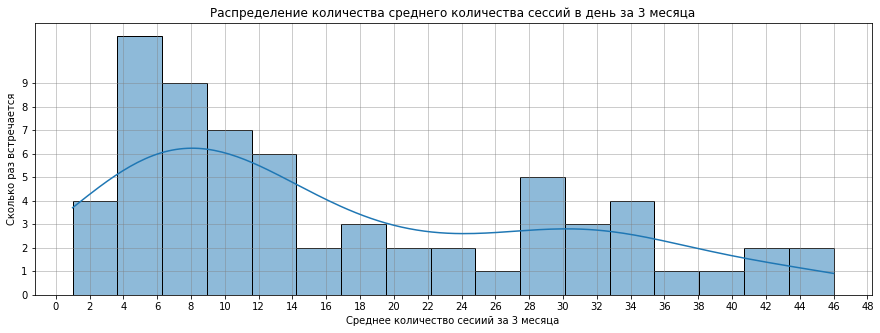

In [40]:
plt.figure(figsize=(15, 5))
sns.histplot(data=df_group_sess_days[df_group_sess_days['count_session'] < 50], x="count_session", kde=True, bins=17)
plt.title('Распределение количества среднего количества сессий в день за 3 месяца')
plt.ylabel('Сколько раз встречается')
plt.xlabel('Среднее количество сесиий за 3 месяца')
plt.grid(color='grey', axis='both', alpha=0.5)
plt.xticks(np.arange(0, 50, 2))
plt.yticks(np.arange(0, 10, 1))
plt.show()

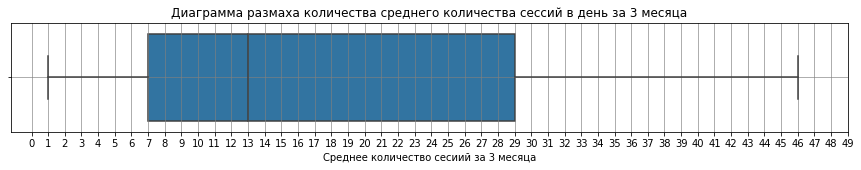

In [41]:
plt.rcParams['figure.figsize']=(15, 2)
sns.boxplot(x=df_group_sess_days['count_session'][df_group_sess_days['count_session'] < 50])
plt.title('Диаграмма размаха количества среднего количества сессий в день за 3 месяца')
plt.xlabel('Среднее количество сесиий за 3 месяца')
plt.grid(color='grey', axis='both', alpha=.8)
plt.xticks(np.arange(0, 50, 1))
plt.show()

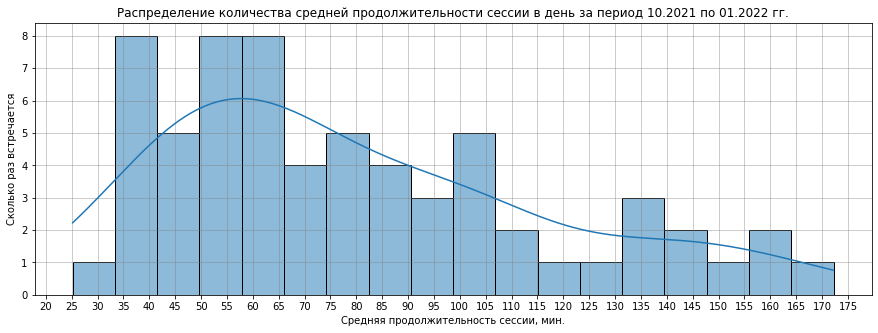

In [42]:
plt.figure(figsize=(15, 5))
sns.histplot(data=df_group_sess_days[df_group_sess_days['mean_time'] < 200], x="mean_time", kde=True, bins=18)
plt.title('Распределение количества средней продолжительности сессии в день за период 10.2021 по 01.2022 гг.')
plt.ylabel('Сколько раз встречается')
plt.xlabel('Средняя продолжительность сессии, мин.')
plt.grid(color='grey', axis='both', alpha=0.5)
plt.xticks(np.arange(20, 180, 5))

plt.show()

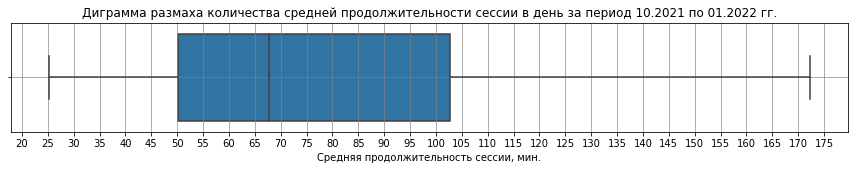

In [43]:
plt.rcParams['figure.figsize']=(15, 2)
sns.boxplot(x=df_group_sess_days['mean_time'][df_group_sess_days['mean_time'] < 200])
plt.title('Диграмма размаха количества средней продолжительности сессии в день за период 10.2021 по 01.2022 гг.')
plt.xlabel('Средняя продолжительность сессии, мин.')
plt.grid(color='grey', axis='both', alpha=.8)
plt.xticks(np.arange(20, 180, 5))

plt.show()

## Шаг 3. Определим количество требуемых лицензий

Выведем на экран, среднее среднего числа сессий, среднее серднего времени использования лицензий:

In [46]:
df_group_sess_days['count_session'].mean()

18.671641791044777

In [49]:
df_group_sess_days['mean_time'].mean()

92.33880597014925

Исходные данные:  
За 480 минут (8 часовой рабочий день) в среднем `18.67` сессий с ипользованием лицензий.  Среднее время использования лицензии `92.34` минут.  
Найдем оптимальное число лицензий для использования ПО ЛОЦМАН:

In [50]:
day_duration = 8 # продолжительность рабочего дня
clients = 18.67 # среднее число сессий
lambda_m = clients / day_duration # час^-1 интенсивность потока
t = 92.34/60 # среднее время использовании одной лицензии, час
nu = 1 / t # интенсивность использования лицензии, час^-1

ro = lambda_m / nu # интенсивность нагрузки

По формуле Эрланга определим вероятность того, что пользователь лицензию получил, при этом найдем значения вероятности при количестве лицензий от 1 до 10:

In [52]:
n = 10 # максимальное число лицензий
n_column = []

for j in range(1, n+1):
  po = 1
  count = 0

  for i in range(1, j+1):
    count= ro ** i / factorial(i)
    po += count

  po = po ** -1  
  p_otkaza = (ro ** j) * po / factorial(j)
  p_obsl = 1 - p_otkaza
  n_column.append([j, p_obsl])

columns = ['number_of_lic', 'p_give']
df_number_lic = pd.DataFrame(n_column, columns=columns) 

df_number_lic

,number_of_lic,p_give
0,1,0.217787
1,2,0.415850
2,3,0.588459
3,4,0.730179
4,5,0.837647
5,6,0.911423
6,7,0.956528
7,8,0.980856
8,9,0.992418
9,10,0.997284


Оптимальное количество лицензий можно считать `n = 7`, когда пользователь с вероятностью `95.7 %` получит лицензию. 

## Шаг 4. Вывод

Исходя из анализа *.log файлов сессий пользователей при использовании ЛОЦМАН:КБ начиная с 01.10.2021 г. по 19.01.2022 г. были определены статистические показатели портера пользователя.  
Данные показатели позволили определить среднее число сессий, среднее время использования лицензий, на основании которых выполнен расчет по определению оптимального числа лицензий.  
При закупке программного обеспечения ЛОЦМАН:КБ, оптимальное количество лицензий:  `7 штук`, такое количество лицензий позволит с вероятностью `95.7 %` получить пользователю доступ к программе.